In [1]:
# PyTorch Specific libraries
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningModule, Trainer


# Data manipulation and visualization specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# For splitting the data into Train and Test set
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

# Set the working directory
import os
os.chdir("/home/labpc6c/Documents/Mo_emam/GID_mo_emam/")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [2]:
# Load dataset
# Read protein data from CSV file
protein = pd.read_csv("./proteomics_all_20221214.csv", sep=",")

# Pivot protein data table and fill missing values with 0
new_protein_df = protein.pivot_table(index="symbol", columns="model_id", values="zscore")
new_protein_df = new_protein_df.fillna(0)

# Transpose the pivoted protein data table
train1 = new_protein_df.T
print('trained_dt:\n', train1.shape)

# Read metadata from CSV file
meta_adata = pd.read_csv("./model_list_20230517.csv", sep=",")

# Set index of metadata to 'model_id'
meta_data = meta_adata.set_index("model_id")

# Filter metadata based on columns of protein data
final_meta_data = meta_data.loc[new_protein_df.columns]

# Create a new column 'one_vs_rest' based on 'tissue_status'
final_meta_data['one_vs_rest'] = final_meta_data['tissue_status'].apply(lambda x: 0 if x == 'Metastasis' else 1)

# Extract labels from metadata
label_train1 = final_meta_data['one_vs_rest'].values
print('label_train1:\n', label_train1.shape)


trained_dt:
 (948, 8457)
label_train1:
 (948,)


In [3]:
final_meta_data['tissue_status']

model_id
SIDM00018        Tumour
SIDM00023       Unknown
SIDM00040       Unknown
SIDM00041       Unknown
SIDM00042       Unknown
                ...    
SIDM01248        Tumour
SIDM01251        Tumour
SIDM01259        Tumour
SIDM01261    Metastasis
SIDM01265        Tumour
Name: tissue_status, Length: 948, dtype: object

In [4]:
# Take a look
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train1, label_train1, test_size=0.3, random_state=1)

# Rescaling values
max_value_train = X_train.max().max()  # Get the maximum value in the DataFrame
max_value_test = X_test.max().max()  # Get the maximum value in the DataFrame

X_train = X_train.values / max_value_train
X_test = X_test.values / max_value_test

y_train = y_train.astype('float64')  # Convert to a supported data type
y_test = y_test.astype('float64')  # Convert to a supported data type



# Machine learing_part

In [5]:
def ML_Pipeline(X_train, y_train, feature_names=None, test=False, X_test=None, y_test=None):
    """
    Machine Learning Pipeline for training and evaluating classifiers.

    Args:
    - X_train (numpy array): Training features.
    - y_train (numpy array): Training labels.
    - feature_names (list, optional): List of feature names.
    - test (bool, optional): Whether to perform testing.
    - X_test (numpy array, optional): Testing features.
    - y_test (numpy array, optional): Testing labels.

    Returns:
    - results (DataFrame): Results of grid search cross-validation.
    - estimators (dict): Best estimators for each model.
    - fpr (numpy array): False positive rates for ROC curve.
    - tpr (numpy array): True positive rates for ROC curve.
    - feature_importance_df (DataFrame): Feature importance for each model.
    """

    # evaluation - baselines
    num_folds = 5
    seed = 7
    scoring = 'accuracy'  # Change scoring to accuracy
    models = []
    models.append(('GBM', GradientBoostingClassifier(learning_rate=0.001)))

    hyperparameters = {
        'GBM': {'n_estimators': [100, 500, 1000]}
    }

    results = {}
    names = []
    estimators = {}
    feature_importance = {}

    print('Model', 'val_mean_score', 'val_std_score')
    for name, model in models:
        GS = GridSearchCV(model, hyperparameters[name], scoring=scoring, cv=num_folds)
        GS_fit = GS.fit(X_train, y_train)
        best_index = GS_fit.best_index_
        results[name] = pd.DataFrame(GS_fit.cv_results_).drop('params', axis=1).loc[best_index]
        estimators[name] = GS_fit.best_estimator_
        feature_importance[name] = estimators[name].feature_importances_  # Get feature importance
        names.append(name)
        msg = (name, pd.DataFrame(GS_fit.cv_results_).drop('params', axis=1).loc[best_index, 'mean_test_score'],
               pd.DataFrame(GS_fit.cv_results_).loc[best_index, 'std_test_score'])

        print(msg)

        if test:
            y_pred = estimators[name].predict(X_test)
            print("test_score", accuracy_score(y_pred, y_test))

            if hasattr(estimators[name], 'predict_proba'):
                fpr, tpr, thresholds = roc_curve(y_test, estimators[name].predict_proba(X_test)[:, 1])
                roc_auc = auc(fpr, tpr)

                plt.figure()
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for {name}')
                plt.legend(loc='lower right')
                plt.show()

    # Display feature importance
    feature_importance_df = pd.DataFrame(feature_importance[name], columns=['Importance'])
    if feature_names is not None:
        feature_importance_df['Feature'] = feature_names
        feature_importance_df = feature_importance_df[['Feature', 'Importance']]
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # compare algorithms
    fig = plt.figure()
    fig.suptitle('TCGA contrast')
    ax = fig.add_subplot(111)
    plt.boxplot(np.array([results[i][[i for i in results[i].index if ('_test_score' in i) & ('split' in i)]].values for i in names]).T)
    ax.set_xticklabels(names)
    plt.ylim([0, 1])
    plt.show()

    return pd.DataFrame(results), estimators, fpr, tpr

# Example usage:
# result_df, trained_estimators, fpr, tpr, feature_importance_df = ML_Pipeline(X_train, y_train, feature_names=X_train.columns, test=True, X_test=X_test, y_test=y_test)


Model val_mean_score val_std_score
('GBM', 0.6817612212349055, 0.004809578419488305)
test_score 0.7192982456140351


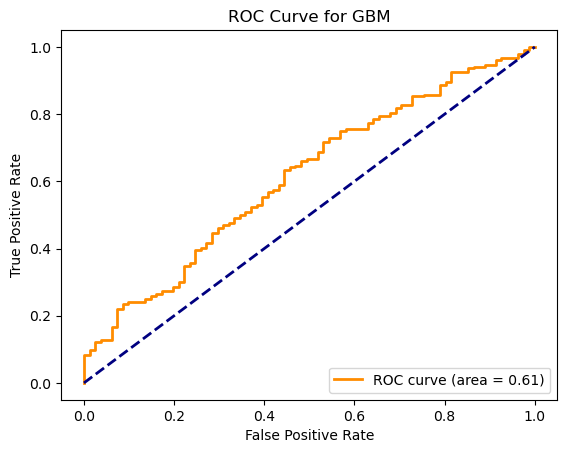

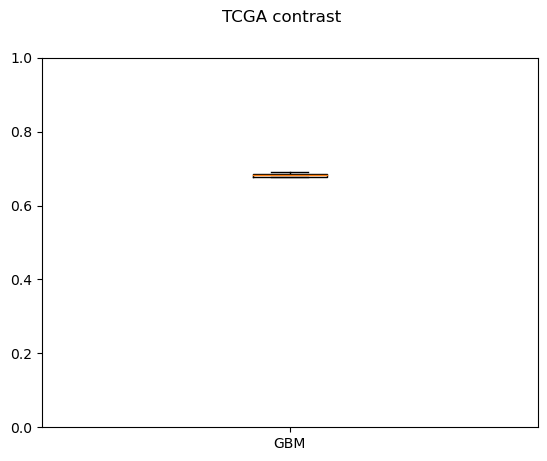

In [6]:
results, Models, fpr, tpr= ML_Pipeline(X_train,y_train,test=True,X_test= X_test,y_test = y_test)

## Deep learning part

Fold [1/5]
Finished Training
Fold [2/5]
Finished Training
Fold [3/5]
Finished Training
Fold [4/5]
Finished Training
Fold [5/5]
Finished Training


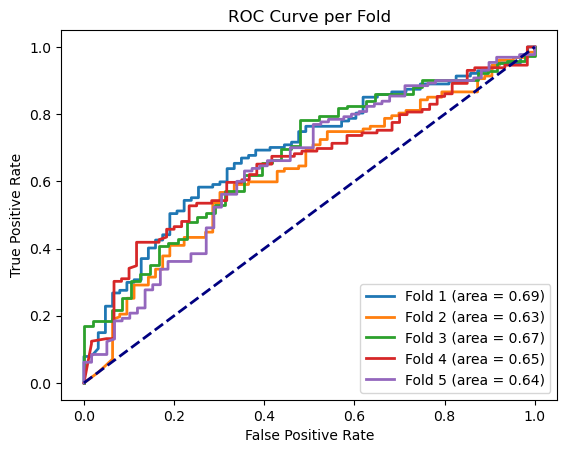

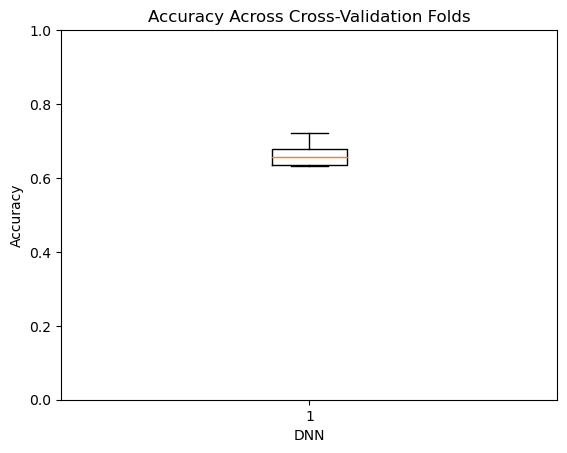

Mean test_accuracy: 66.45391255917572


In [7]:
# Converting to Tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Combine the entire dataset
X = torch.cat((X_train, X_test), dim=0)
y = torch.cat((y_train, y_test), dim=0)

# Set up the cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 50

# Lists to store labels, scores, and accuracies across folds
all_labels = []
all_scores = []
fold_accuracies = []

# Create a figure for the ROC curves
plt.figure()

# Iterate over each fold in the KFold cross-validation
for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
    print(f'Fold [{fold + 1}/5]')

    # Split data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    # Convert data into PyTorch TensorDataset
    train_fold = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
    test_fold = torch.utils.data.TensorDataset(X_test_fold, y_test_fold)

    # Set batch size for data loaders
    batch_size = 100

    # Create data loaders for training and testing sets
    train_loader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_fold, batch_size=batch_size, shuffle=False)

    # Define the neural network model
    class TCGAcontrast(nn.Module):
        def __init__(self):
            super(TCGAcontrast, self).__init__()
            self.fc1 = nn.Linear(8457, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 2)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Initialize the model, criterion, and optimizer
    model = TCGAcontrast()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model for the specified number of epochs
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}], Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

    print('Finished Training')

    # Evaluate the model on the testing set for the current fold
    model.eval()
    fold_labels = []
    fold_scores = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            fold_labels.extend(labels.numpy())
            fold_scores.extend(F.softmax(outputs, dim=1)[:, 1].numpy())

    # Calculate accuracy for the current fold
    fold_predictions = (np.array(fold_scores) > 0.5).astype(int)
    fold_accuracy = accuracy_score(fold_labels, fold_predictions)
    fold_accuracies.append(fold_accuracy)

    # Calculate ROC curve for the current fold
    fpr, tpr, _ = roc_curve(fold_labels, fold_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for the current fold with a different color
    plt.plot(fpr, tpr, lw=2, label=f'Fold {fold + 1} (area = {roc_auc:.2f})')

# Plot mean ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Fold')
plt.legend(loc='lower right')
plt.show()

# Create a boxplot to visualize the accuracies across folds
plt.figure()
plt.boxplot(fold_accuracies, vert=True)
plt.ylabel('Accuracy')
plt.xlabel('DNN')
plt.title('Accuracy Across Cross-Validation Folds')
plt.ylim([0, 1])
plt.show()

# Calculate mean accuracy
mean_accuracy = np.mean(fold_accuracies) * 100
print("Mean test_accuracy:", mean_accuracy)


In [8]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train1, label_train1, test_size=0.3, random_state=1)

# Rescaling values
max_value_train = X_train.max().max()
max_value_test = X_test.max().max()
X_train = X_train.values / max_value_train
X_test = X_test.values / max_value_test
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

# Converting to Tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Combine the entire dataset
X = torch.cat((X_train, X_test), dim=0)
y = torch.cat((y_train, y_test), dim=0)

# Calculate the maximum number of possible edges
max_edges = X.size(0) * (X.size(0) - 1)

# Limit the number of edges to a fraction of the maximum possible edges
num_edges = min(int(0.2 * max_edges), max_edges)

# Generate random edge indices
edge_index = np.random.choice(max_edges, num_edges, replace=False)
edge_index = np.unravel_index(edge_index, (X.size(0), X.size(0)))

# Define a Data object
data = Data(x=X, edge_index=torch.tensor(edge_index, dtype=torch.long), y=y)

# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return 1  # Since we have only one data point

    def __getitem__(self, idx):
        return self.data

# Create a custom collate function to handle Data objects
def custom_collate(batch):
    return batch[0]

# Create a DataLoader for the custom dataset with the custom collate function
dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)

# Train a simple GCN model
class GCNLightningModule(LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(in_channels=8457, out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=7)
        self.conv3 = GCNConv(in_channels=7, out_channels=2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

    def training_step(self, batch, batch_idx):
        x, edge_index = batch.x, batch.edge_index
        out = self.forward(batch)
        loss = F.cross_entropy(out, batch.y)
        self.log('train_loss', loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, edge_index = batch.x, batch.edge_index
        out = self.forward(batch)
        loss = F.cross_entropy(out, batch.y)
        self.log('val_loss', loss, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

model = GCNLightningModule()
model.to("cpu")

# Set up the Trainer with device set to CPU
trainer = Trainer(max_epochs=10, accelerator="cpu")  # num_gpus=0 means using CPU
trainer.fit(model, dataloader)

# Function to calculate accuracy
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            # Move data to the device
            data = data.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()
    return correct / total

# Evaluate the model on the test set
model.eval()
test_accuracy = calculate_accuracy(model, dataloader)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')


Using device: cpu


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-04-10 11:09:00.200103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 11:09:01.485441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name  | Type    | Params
----------------------------------
0 | conv1 | GCNConv | 135 K 
1 | conv2 | GCNConv | 119   
2 | conv3 | GCNConv | 16    
----------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Test Accuracy: 0.6909


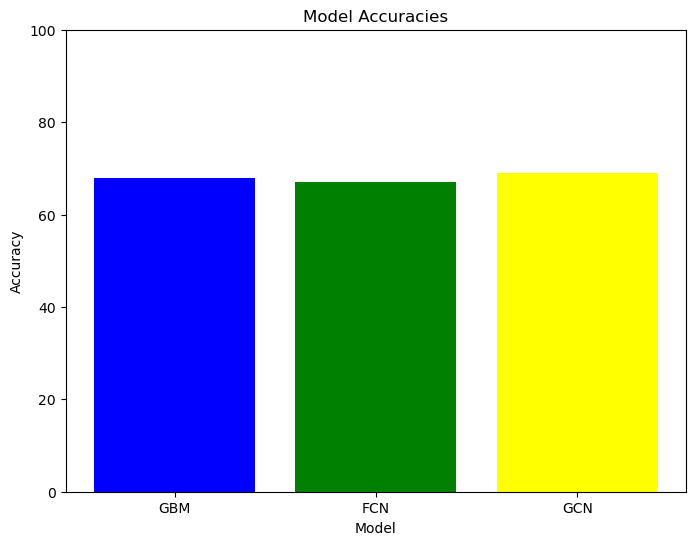

In [9]:
import matplotlib.pyplot as plt

# Model accuracies
model_accuracies = {"GBM": 68, "FCN": 67, "GCN": 69}

# Extract model names and accuracies
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Plot the bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', "yellow"])  # Customize the colors as needed
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 100)  # Set y-axis limits to ensure readability
plt.show()
